In [1]:
import pandas as pd
import requests
import numpy as np

In [2]:
# Fetch Kline data from Binance API

def get_klines(symbol="BTCUSDT", interval="1h", limit=1000):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    
    raw = requests.get(url, params=params).json()

    cols = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_volume", "trades", 
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    
    df = pd.DataFrame(raw, columns=cols)
    df["open_time"]  = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")

    # Ensure numeric cols are numeric (coerce any stray strings)
    numeric_cols = [
        "open", "high", "low", "close", "volume", "quote_volume",
        "taker_buy_base", "taker_buy_quote"
    ]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Optionally drop the 'ignore' text column
    if "ignore" in df.columns:
        df = df.drop(columns=["ignore"])

    # numeric_cols = ["open","high","low","close","volume","quote_volume"]
    # df[numeric_cols] = df[numeric_cols].astype(float)

    return df

klines_df = get_klines()


In [3]:
# check for missing values and data types
print(klines_df.isna().sum())
print(klines_df.dtypes)

open_time          0
open               0
high               0
low                0
close              0
volume             0
close_time         0
quote_volume       0
trades             0
taker_buy_base     0
taker_buy_quote    0
dtype: int64
open_time          datetime64[ns]
open                      float64
high                      float64
low                       float64
close                     float64
volume                    float64
close_time         datetime64[ns]
quote_volume              float64
trades                      int64
taker_buy_base            float64
taker_buy_quote           float64
dtype: object


In [4]:
# CVD Approximation
def calculate_cvd_approximation(klines_df):
    """
    Calculate Cumulative Volume Delta (CVD) approximation from Binance klines data.
    
    Args:
        klines_df: DataFrame with Binance klines columns including 'taker_buy_base' and 'volume'
    
    Returns:
        DataFrame with CVD columns added
    """
    df = klines_df.copy()
    
    # Approximate buy and sell volumes
    df['buy_volume'] = df['taker_buy_base']
    df['sell_volume'] = df['volume'] - df['taker_buy_base']
    
    # Calculate per-bar delta
    df['volume_delta'] = df['buy_volume'] - df['sell_volume']
    
    # Calculate cumulative volume delta
    df['cvd'] = df['volume_delta'].cumsum()
    
    # Buy/sell ratio per bar
    df['buy_sell_ratio'] = df['buy_volume'] / df['sell_volume'].replace(0, 1)
    
    return df


def calculate_cvd_features(df, windows=[5, 10, 20]):
    """
    Calculate rolling CVD features.
    
    Args:
        df: DataFrame with CVD columns
        windows: List of lookback periods
    
    Returns:
        DataFrame with CVD features added
    """
    for window in windows:
        # CVD slope (trend in buying pressure)
        df[f'cvd_slope_{window}'] = df['cvd'].diff(window) / window
        
        # Average volume delta
        df[f'avg_volume_delta_{window}'] = df['volume_delta'].rolling(window).mean()
        
        # Average buy/sell ratio
        df[f'avg_buy_sell_ratio_{window}'] = df['buy_sell_ratio'].rolling(window).mean()
    
    return df

In [5]:
# Calculate CVD approximation and features
klines_with_cvd = calculate_cvd_approximation(klines_df)
klines_with_cvd = calculate_cvd_features(klines_with_cvd, windows=[5, 10, 20])

In [6]:
klines_with_cvd.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote',
       'buy_volume', 'sell_volume', 'volume_delta', 'cvd', 'buy_sell_ratio',
       'cvd_slope_5', 'avg_volume_delta_5', 'avg_buy_sell_ratio_5',
       'cvd_slope_10', 'avg_volume_delta_10', 'avg_buy_sell_ratio_10',
       'cvd_slope_20', 'avg_volume_delta_20', 'avg_buy_sell_ratio_20'],
      dtype='object')

In [7]:
klines_with_cvd.isna().sum()

open_time                 0
open                      0
high                      0
low                       0
close                     0
volume                    0
close_time                0
quote_volume              0
trades                    0
taker_buy_base            0
taker_buy_quote           0
buy_volume                0
sell_volume               0
volume_delta              0
cvd                       0
buy_sell_ratio            0
cvd_slope_5               5
avg_volume_delta_5        4
avg_buy_sell_ratio_5      4
cvd_slope_10             10
avg_volume_delta_10       9
avg_buy_sell_ratio_10     9
cvd_slope_20             20
avg_volume_delta_20      19
avg_buy_sell_ratio_20    19
dtype: int64

In [8]:
# backfill missing values if any
klines_with_cvd = klines_with_cvd.fillna(method='bfill')

C:\Users\User\AppData\Local\Temp\ipykernel_7224\3010248785.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  klines_with_cvd = klines_with_cvd.fillna(method='bfill')


In [9]:
klines_with_cvd.isna().sum()

open_time                0
open                     0
high                     0
low                      0
close                    0
volume                   0
close_time               0
quote_volume             0
trades                   0
taker_buy_base           0
taker_buy_quote          0
buy_volume               0
sell_volume              0
volume_delta             0
cvd                      0
buy_sell_ratio           0
cvd_slope_5              0
avg_volume_delta_5       0
avg_buy_sell_ratio_5     0
cvd_slope_10             0
avg_volume_delta_10      0
avg_buy_sell_ratio_10    0
cvd_slope_20             0
avg_volume_delta_20      0
avg_buy_sell_ratio_20    0
dtype: int64

In [10]:
# fetch funding rate 

def get_funding_rates(symbol="BTCUSDT", limit=1000):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    params = {"symbol": symbol, "limit": limit}
    
    raw = requests.get(url, params=params).json()

    df = pd.DataFrame(raw)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms")
    df["fundingRate"] = df["fundingRate"].astype(float)
    
    return df

funding_df = get_funding_rates()

In [11]:
funding_df.tail(1)

,symbol,fundingTime,fundingRate,markPrice
199,BTCUSDT,2025-11-23 16:00:00.003,-0.000009,87043.56694928


In [12]:
# def merge_features(klines_df, funding_df):
#     # Funding timestamp aligns better with close_time
#     merged = pd.merge_asof(
#         klines_df.sort_values("close_time"),
#         funding_df.sort_values("fundingTime"),
#         left_on="close_time",
#         right_on="fundingTime",
#         direction="backward"
#     )

#     # Keep main features
#     return merged[[
#         "close_time", "close", "volume", "fundingRate"
#     ]]

def merge_all_features(klines_df, funding_df):
    """
    Merge klines, CVD features, and funding rates into single DataFrame.
    
    Args:
        klines_df: DataFrame from get_klines()
        funding_df: DataFrame from get_funding_rates()
    
    Returns:
        DataFrame with all features aligned by time
    """
    # Step 1: Calculate CVD on klines data
    klines_with_cvd = calculate_cvd_approximation(klines_df)
    
    # Step 2: Calculate CVD features
    klines_with_cvd = calculate_cvd_features(klines_with_cvd, windows=[5, 10, 20])
    
    # Step 3: Merge with funding rates
    merged = pd.merge_asof(
        klines_with_cvd.sort_values("close_time"),
        funding_df.sort_values("fundingTime"),
        left_on="close_time",
        right_on="fundingTime",
        direction="backward"
    )
    
    # Step 4: Select and order columns
    # Keep time, price, volume, CVD features, and funding rate
    feature_cols = [
        "close_time",
        "open", "high", "low", "close",
        "volume",
        "buy_volume", "sell_volume", "volume_delta",
        "cvd", "buy_sell_ratio", "cvd_slope_5", "avg_volume_delta_5", "avg_buy_sell_ratio_5",
        "cvd_slope_10", "avg_volume_delta_10", "avg_buy_sell_ratio_10",
        "cvd_slope_20", "avg_volume_delta_20", "avg_buy_sell_ratio_20"
    ]

    
    # Add rolling CVD features
    cvd_feature_cols = [col for col in merged.columns if col.startswith(('cvd_slope_', 'avg_volume_delta_', 'avg_buy_sell_ratio_'))]
    feature_cols.extend(cvd_feature_cols)
    
    # Add funding rate
    feature_cols.append("fundingRate")
    
    return merged[feature_cols]

In [13]:
# kl = get_klines("BTCUSDT", interval="1h", limit=1000)
# fr = get_funding_rates("BTCUSDT", limit=1000)
features = merge_all_features(klines_df, funding_df)


In [14]:
features = features.fillna(method='bfill')

C:\Users\User\AppData\Local\Temp\ipykernel_7224\3474506326.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='bfill')


In [15]:
print(features.describe())

                          close_time           open           high  \
count                           1000    1000.000000    1000.000000   
mean   2025-11-02 21:29:59.999000320  104275.706510  104623.839810   
min       2025-10-13 01:59:59.999000   82207.830000   82911.990000   
25%    2025-10-23 11:44:59.999000064  100804.512500  101423.497500   
50%    2025-11-02 21:29:59.999000064  106824.805000  107118.830000   
75%    2025-11-13 07:14:59.999000064  110673.502500  111026.195000   
max       2025-11-23 16:59:59.999000  116053.500000  116400.000000   
std                              NaN    8345.210959    8312.658963   

                 low          close        volume   buy_volume  sell_volume  \
count    1000.000000    1000.000000   1000.000000  1000.000000  1000.000000   
mean   103853.527620  104247.593320   1073.456504   511.811245   561.645259   
min     80600.000000   82207.840000    109.985510    39.018360    51.922510   
25%    100337.737500  100791.175000    494.991400   2

In [16]:
features.columns

Index(['close_time', 'open', 'high', 'low', 'close', 'volume', 'buy_volume',
       'sell_volume', 'volume_delta', 'cvd', 'buy_sell_ratio', 'cvd_slope_5',
       'avg_volume_delta_5', 'avg_buy_sell_ratio_5', 'cvd_slope_10',
       'avg_volume_delta_10', 'avg_buy_sell_ratio_10', 'cvd_slope_20',
       'avg_volume_delta_20', 'avg_buy_sell_ratio_20', 'cvd_slope_5',
       'avg_volume_delta_5', 'avg_buy_sell_ratio_5', 'cvd_slope_10',
       'avg_volume_delta_10', 'avg_buy_sell_ratio_10', 'cvd_slope_20',
       'avg_volume_delta_20', 'avg_buy_sell_ratio_20', 'fundingRate'],
      dtype='object')

In [17]:
# Trple barrier 

def add_triple_barrier_labels(df, 
                              profit_target_pct=0.015, 
                              stop_loss_pct=0.01, 
                              time_barrier_bars=20):
    """
    Add triple barrier labels to existing features DataFrame.
    
    Args:
        df: DataFrame with OHLCV columns (must have 'open', 'high', 'low', 'close')
        profit_target_pct: Profit target as percentage (e.g., 0.015 = 1.5%)
        stop_loss_pct: Stop loss as percentage (e.g., 0.01 = 1%)
        time_barrier_bars: Maximum holding period in bars
    
    Returns:
        DataFrame with added columns: 'label', 'barrier_hit', 'return', 'bars_held'
    """
    
    result_df = df.copy()
    
    # Initialize label columns
    result_df['label'] = np.nan
    result_df['barrier_hit'] = None
    result_df['return'] = np.nan
    result_df['bars_held'] = np.nan
    
    # Can't label last time_barrier_bars
    max_idx = len(result_df) - time_barrier_bars - 1
    
    for i in range(max_idx):
        entry_price = result_df['close'].iloc[i]
        
        # Set barriers
        upper_barrier = entry_price * (1 + profit_target_pct)
        lower_barrier = entry_price * (1 - stop_loss_pct)
        
        # Look forward
        barrier_hit = None
        bars_held = 0
        exit_price = entry_price
        
        for j in range(i + 1, min(i + time_barrier_bars + 1, len(result_df))):
            bars_held = j - i
            
            # Check upper barrier (profit target)
            if result_df['high'].iloc[j] >= upper_barrier:
                barrier_hit = 'upper'
                exit_price = upper_barrier
                break
            
            # Check lower barrier (stop loss)
            if result_df['low'].iloc[j] <= lower_barrier:
                barrier_hit = 'lower'
                exit_price = lower_barrier
                break
        
        # Time barrier if neither price barrier hit
        if barrier_hit is None:
            barrier_hit = 'time'
            exit_idx = min(i + time_barrier_bars, len(result_df) - 1)
            exit_price = result_df['close'].iloc[exit_idx]
            bars_held = exit_idx - i
        
        # Assign label: 1 (profit), -1 (loss), 0 (time)
        if barrier_hit == 'upper':
            label = 1
        elif barrier_hit == 'lower':
            label = -1
        else:
            label = 0
        
        # Calculate return
        ret = (exit_price - entry_price) / entry_price
        
        # Store in DataFrame
        result_df.iloc[i, result_df.columns.get_loc('label')] = label
        result_df.iloc[i, result_df.columns.get_loc('barrier_hit')] = barrier_hit
        result_df.iloc[i, result_df.columns.get_loc('return')] = ret
        result_df.iloc[i, result_df.columns.get_loc('bars_held')] = bars_held
    
    # Drop rows without labels (last time_barrier_bars rows)
    result_df = result_df.dropna(subset=['label'])
    
    # Convert label to int
    result_df['label'] = result_df['label'].astype(int)
    result_df['bars_held'] = result_df['bars_held'].astype(int)
    
    # print(f"Labeled {len(result_df)} rows")
    # print(f"\nLabel distribution:")
    # print(result_df['label'].value_counts().sort_index())
    # print(f"\nLabel percentages:")
    # print(result_df['label'].value_counts(normalize=True).sort_index() * 100)
    
    return result_df

In [18]:
# Add labels
labeled_df = add_triple_barrier_labels(
    features,
    profit_target_pct=0.005,
    stop_loss_pct=0.015,
    time_barrier_bars= 20
)

<Axes: >

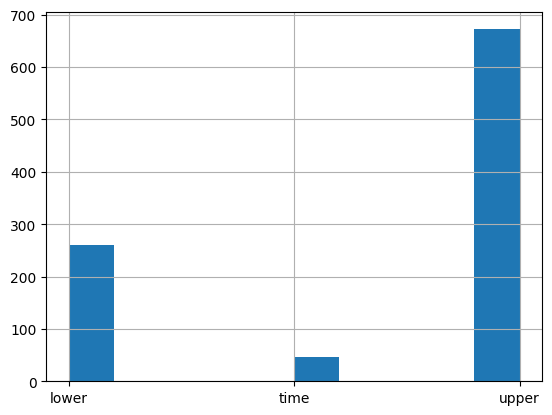

In [19]:
labeled_df.barrier_hit.hist()

In [20]:
print(list(labeled_df.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [86]:
# examine the joint distributions of the barrier_hits and other features
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Pairplot of selected features colored by barrier_hit
selected_features = ['cvd_slope_5', 'avg_volume_delta_5', 'fundingRate', 'label']
sns.pairplot(labeled_df[selected_features], hue='label')    

ValueError: Data must be 1-dimensional, got ndarray of shape (979, 2) instead

In [87]:
# Quick checks and fix for columns with non-scalar entries
import numpy as np

selected_features = ['cvd_slope_5', 'avg_volume_delta_5', 'fundingRate', 'label']

# 1) show dtypes and a sample of types inside each column
print(labeled_df[selected_features].dtypes)
for c in selected_features:
    print("\nCOLUMN:", c)
    print(labeled_df[c].apply(lambda x: type(x)).value_counts().head(10))

# 2) find rows where a column contains a sequence/array (but not strings)
def is_sequence_scalar(x):
    return (hasattr(x, '__len__') and not isinstance(x, (str, bytes, bytearray)))

for c in selected_features:
    mask = labeled_df[c].apply(is_sequence_scalar)
    if mask.any():
        print(f"-> {c} has non-scalar entries, sample rows:")
        display(labeled_df.loc[mask, c].head(5))

# 3) Flatten any arrays/lists to scalar (take first element), then coerce to numeric
for c in selected_features:
    labeled_df[c] = labeled_df[c].apply(
        lambda x: (x[0] if isinstance(x, (list, tuple, np.ndarray)) and len(x)>0 else x)
    )
    # numeric conversion for numeric features (ignore 'label' if it's already int)
    if c != 'label':
        labeled_df[c] = pd.to_numeric(labeled_df[c], errors='coerce')

# 4) drop rows with NaNs introduced by coercion (optional)
clean = labeled_df[selected_features].dropna()

# 5) finally plot
import seaborn as sns
sns.pairplot(clean, hue='label')

cvd_slope_5           float64
cvd_slope_5           float64
avg_volume_delta_5    float64
avg_volume_delta_5    float64
fundingRate           float64
label                   int64
dtype: object

COLUMN: cvd_slope_5
<class 'pandas.core.series.Series'>    2
Name: count, dtype: int64

COLUMN: avg_volume_delta_5
<class 'pandas.core.series.Series'>    2
Name: count, dtype: int64

COLUMN: fundingRate
fundingRate
<class 'float'>    979
Name: count, dtype: int64

COLUMN: label
label
<class 'int'>    979
Name: count, dtype: int64
-> cvd_slope_5 has non-scalar entries, sample rows:


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [21]:
features.cvd_slope_5

,cvd_slope_5,cvd_slope_5
0,-154.598474,-154.598474
1,-154.598474,-154.598474
2,-154.598474,-154.598474
3,-154.598474,-154.598474
4,-154.598474,-154.598474
...,...,...
995,27.125228,27.125228
996,39.260888,39.260888
997,14.644600,14.644600
998,24.284356,24.284356
